In [2]:
from pathlib import Path
import subprocess
import time
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def download_icloud(path):
    
    filename = path.name.split('.icloud')[0]
    filename = filename[1:]
    command = f'/usr/bin/brctl download {path}'
    subprocess.run(command.split())
    while not (path.parents[0]/filename).exists():
        time.sleep(0.25)

    return path.parents[0]/filename

def evict_icloud(path):
    
    filename = path.name
    filename = '.'+filename+'.icloud'
    command = f'/usr/bin/brctl evict {path}'
    subprocess.run(command.split())
    #while (path.exists()):
    #    time.sleep(0.25)
    
    return path.parents[0]/filename
        

def collect_max_data():
    
    max_data = np.zeros((11, 11, 141))
    
    file_repository = Path.home()/'iCloud'/'jugaad_data'/'beamforming'/'221209_beamforming_characterization'
    file_list = list(file_repository.glob('*.h5.icloud'))
    
    for i, file in enumerate(file_list):
        downloaded_file = download_icloud(file)
        file_name = downloaded_file.name
        #print(file_name)
        r_ind = int(file_name.split('z')[0].split('r')[-1])//5
        z_ind = int(file_name.split('z')[-1].split('.h5')[0])//5
        h5file = h5py.File(downloaded_file, 'r')
        max_data[r_ind, z_ind, :] = h5file['max_data']['data'][:]
        h5file.close()
        evicted_file = evict_icloud(downloaded_file)
        
        if (i % 5) == 4:
            print(f'Progress = {round(100*(i+1)/len(file_list),1)}%')
        
    return max_data

def collect_image_data(z=0, f=75):
    
    image_data = np.zeros((11, 121, 121,))
    
    file_repository = Path.home()/'iCloud'/'jugaad_data'/'beamforming'/'221209_beamforming_characterization'
    if z < 10:
        file_list = list(file_repository.glob(f'*z0{z}.h5.icloud'))
    else:
        file_list = list(file_repository.glob(f'*z{z}.h5.icloud'))
    
    for i, file in enumerate(file_list):
        downloaded_file = download_icloud(file)
        file_name = downloaded_file.name
        #print(file_name)
        r_ind = int(file_name.split('z')[0].split('r')[-1])//5
        #z_ind = int(file_name.split('z')[-1].split('.h5')[0])//5
        h5file = h5py.File(downloaded_file, 'r')
        #image_data[r_ind,:,:] = h5file['image_data']['data'][:,:,:].mean(axis=-1)
        image_data[r_ind,:,:] = h5file['image_data']['data'][:,:,f]
        h5file.close()
        evicted_file = evict_icloud(downloaded_file)
        
        if (i % 5) == 4:
            print(f'Progress = {round(100*(i+1)/len(file_list),1)}%')
        
    return image_data
        

def calculate_total_signal_power():
    
    total_power = np.zeros((11,11,141))
    file_repository = Path.home()/'iCloud'/'jugaad_data'/'beamforming'/'221209_beamforming_characterization'
    file_list = list(file_repository.glob('*.h5.icloud'))
    
    for i, file in enumerate(file_list):
        downloaded_file = download_icloud(file)
        file_name = downloaded_file.name

        r_ind = int(file_name.split('z')[0].split('r')[-1])//5
        z_ind = int(file_name.split('z')[-1].split('.h5')[0])//5
        h5file = h5py.File(downloaded_file, 'r')
        array_data = h5file['array_data']['data'][:, :, 1, 0]

        temp = abs((array_data * np.exp(-1j * np.angle(array_data))).sum(axis=0))
        total_power[r_ind, z_ind, :] = temp      
        h5file.close()
        evicted_file = evict_icloud(downloaded_file)
        
        if (i % 5) == 4:
            print(f'Progress = {round(100*(i+1)/len(file_list),1)}%')
            
    return total_power
        
    

In [3]:
#image_data = collect_image_data(z=15,f=75)

In [4]:
#np.save(
#    Path.home()/'iCloud'/'jugaad_data'/'beamforming'/'221209_beamforming_characterization'/\
#    '230202_beamforming_images_z15.npy',
#    image_data
#)

In [5]:
file_location = Path.home()/'group'/'project'/'datasets'/'data'/'230412_jugaad_analysis'
file_name = '230202_beamforming_images_z00.npy'

image_data = np.load(
    file_location/file_name,
)

In [6]:
image_data.shape

(11, 121, 121)

In [7]:
sns.set_theme(context='paper', style='ticks', font_scale=1.5)

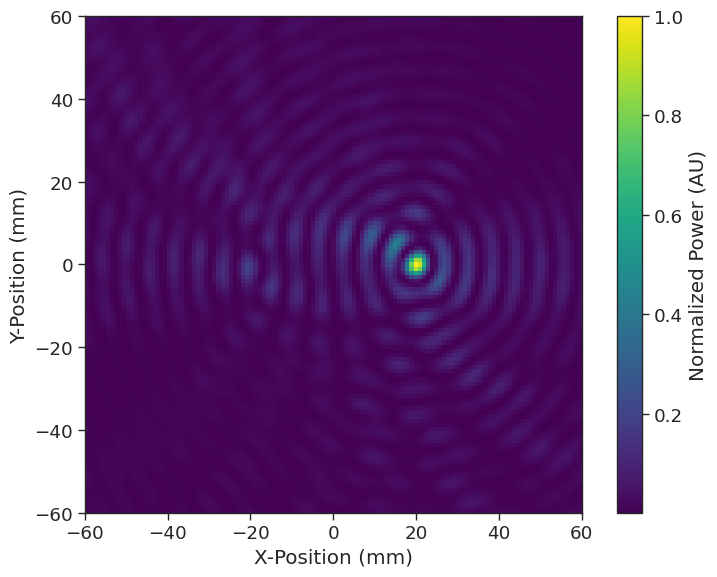

In [9]:
i_rad = 4

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X-Position (mm)')
ax.set_ylabel('Y-Position (mm)')

image = image_data[i_rad,:,:]
image = image/np.max(image)

img = ax.imshow(
    np.flip(image**2, axis=0),
    aspect=1,
    extent=(-60,60,-60,60),
    cmap='viridis'
)
cbar = fig.colorbar(img, label='Normalized Power (AU)')
plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230925_z00r20_jugaad_bf', dpi=150)



# animate

MovieWriter ffmpeg unavailable; using Pillow instead.


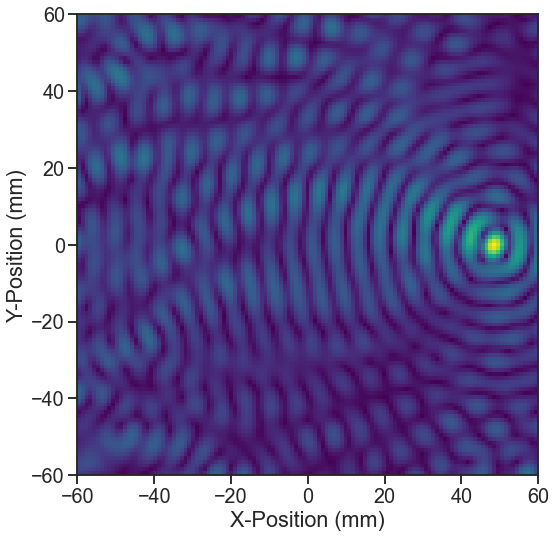

In [150]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel('X-Position (mm)')
ax.set_ylabel('Y-Position (mm)')
radial_positions = -1*np.arange(0,55,5)
ims = []
for i in range(image_data.shape[0]):
    img = ax.imshow(
        np.flip(image_data[i,:,:]**1, axis=0),
        aspect=1,
        extent=(-60,60,-60,60),
        cmap='viridis',
        animated=True,
    )
    #marker, = ax.plot(radial_positions[i], 0,color='r', marker='o', markersize=20, markerfacecolor='none')
    if i == 0:
        ax.imshow(
            np.flip(image_data[0,:,:]**1, axis=0),
            aspect=1,
            extent=(-60,60,-60,60),
            cmap='viridis',
            animated=True,
        )
        plt.tight_layout(pad=1.05)
        
        #ax.plot(0, 0,color='r', marker='o', markersize=20, markerfacecolor='none')
    
    #ims.append([img, marker])
    ims.append([img,])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=False, repeat_delay=500)
ani.save(Path.home()/'iCloud'/'plots'/'230202_z00_jugaad_beamforming_animation.gif',dpi=144)

# make all animations



MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


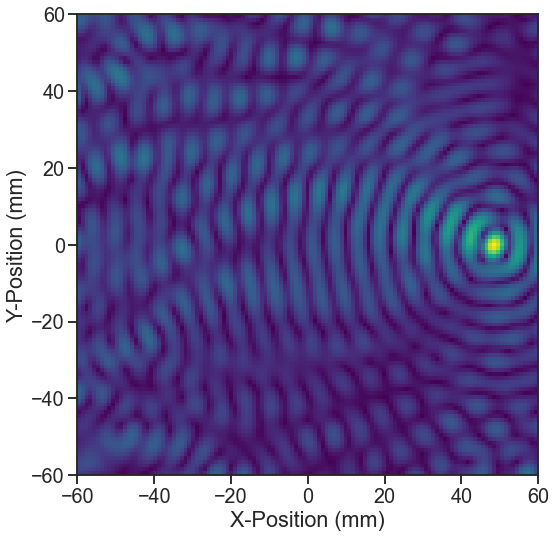

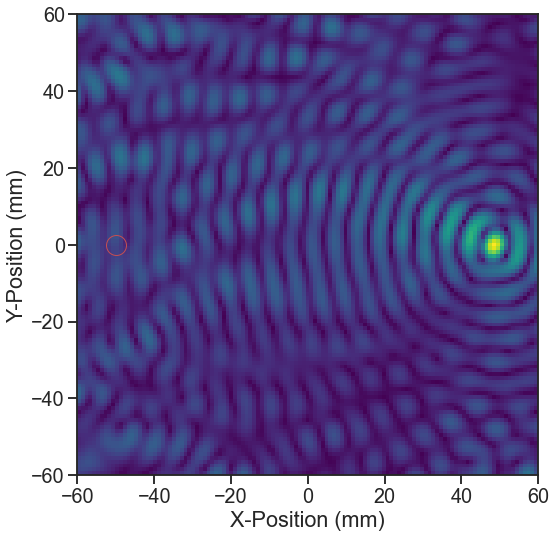

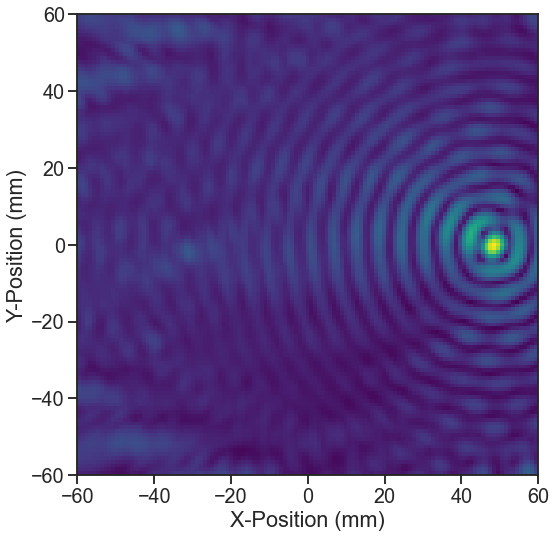

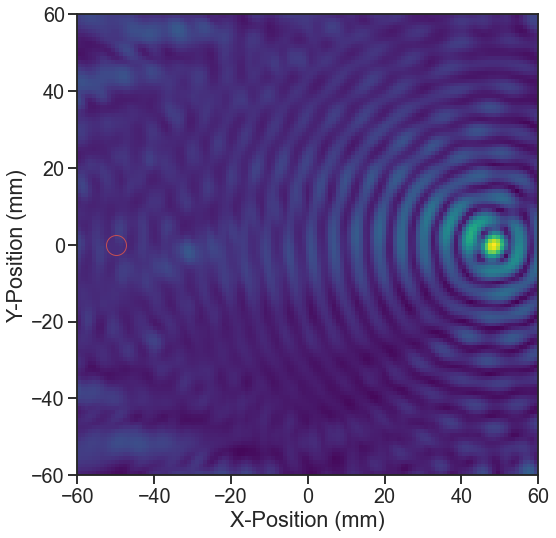

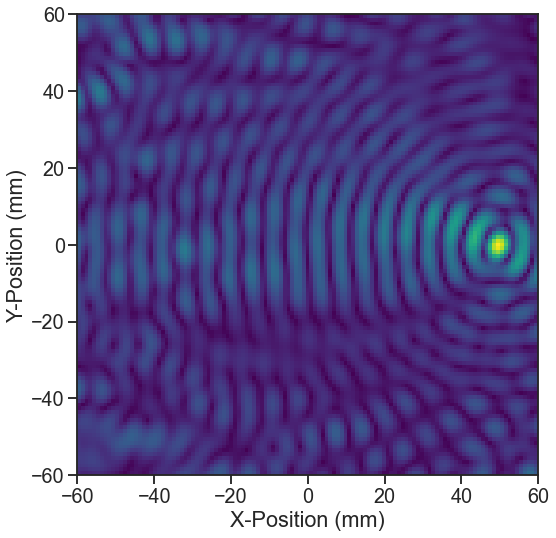

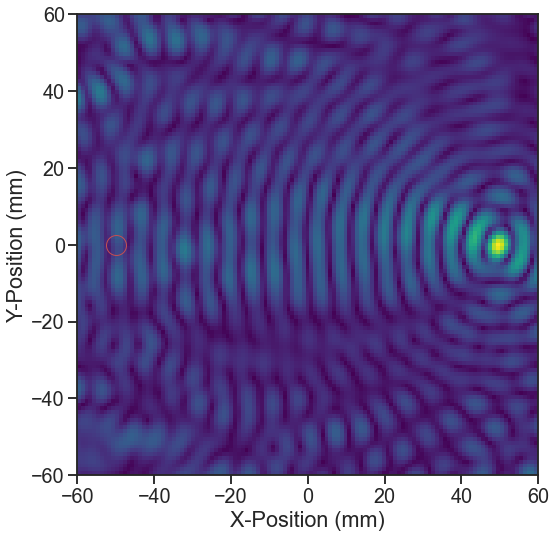

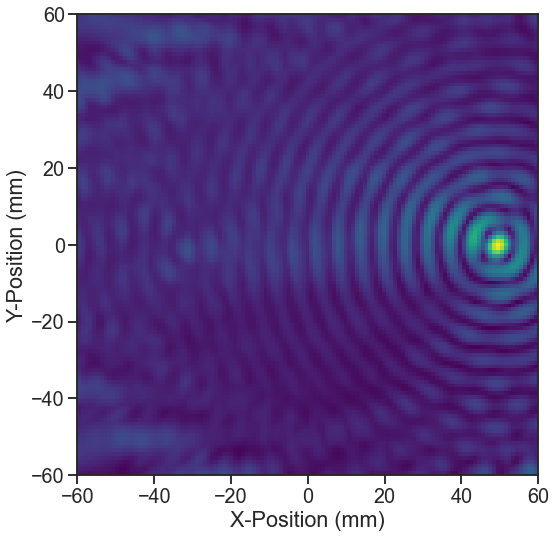

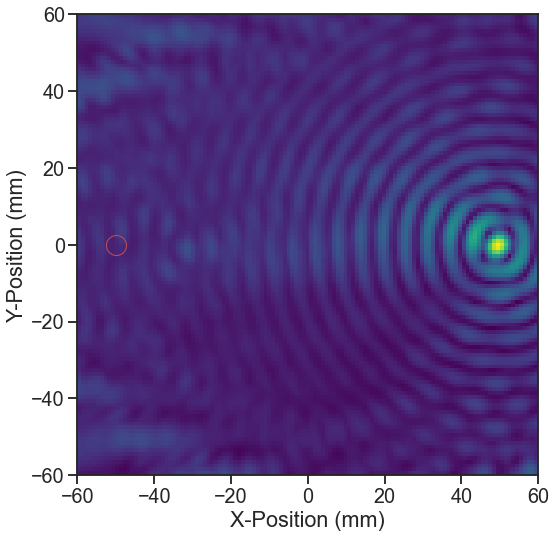

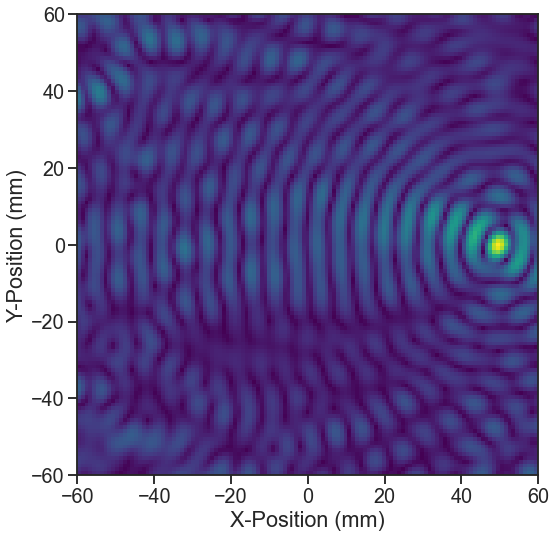

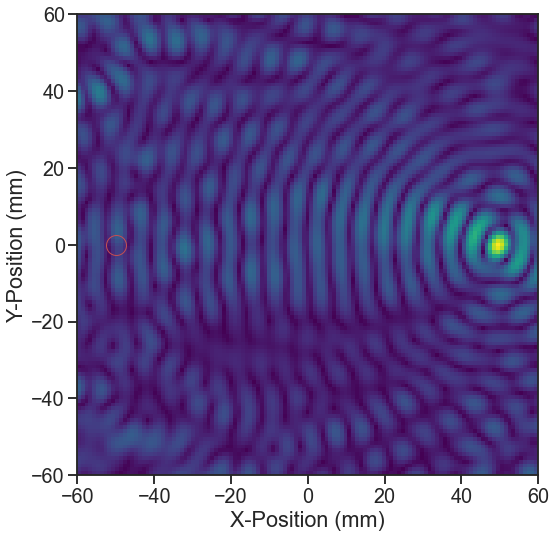

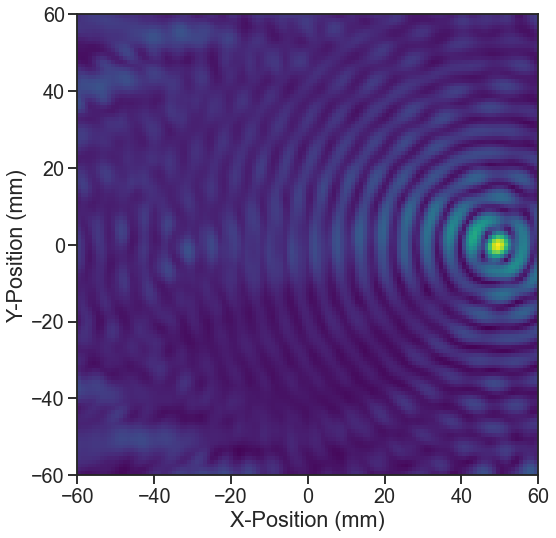

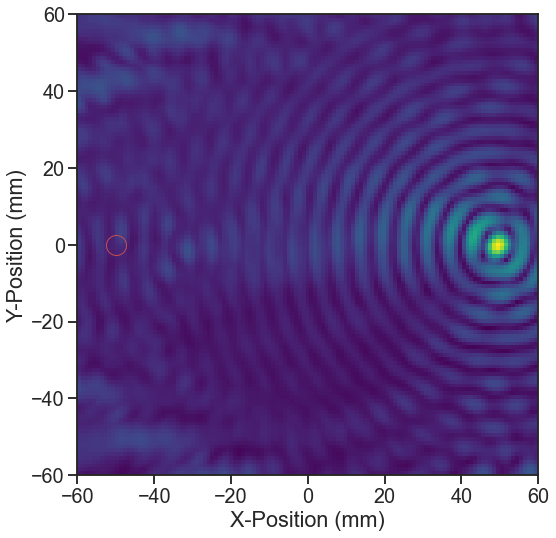

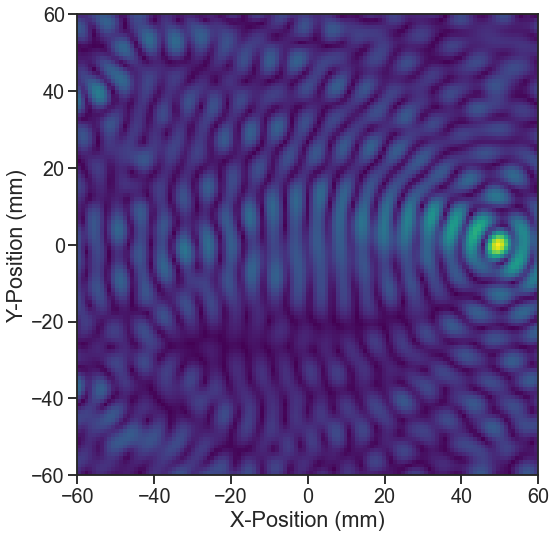

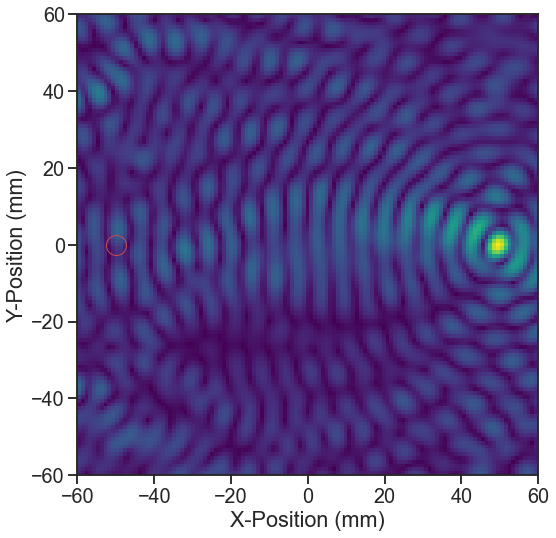

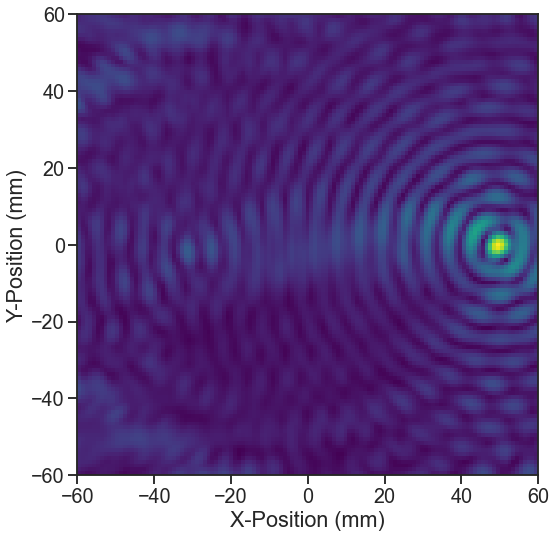

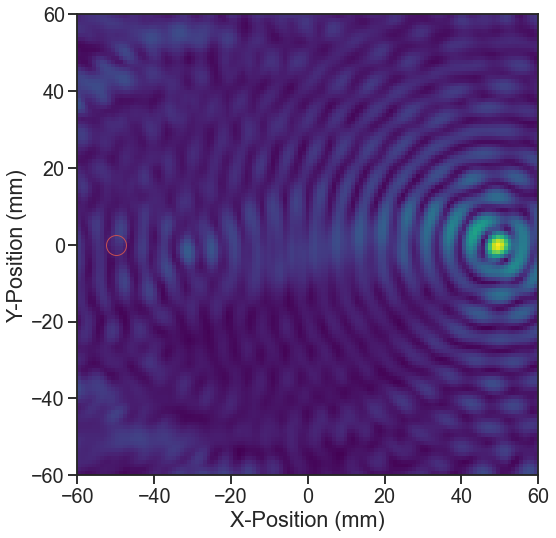

In [155]:
axial_array = np.arange(0,20,5)
    
for i_z in axial_array:
    # load data
    if i_z < 10:
        data_name = f'230202_beamforming_images_z0{i_z}.npy'
        data_name_mean = f'230202_beamforming_images_z0{i_z}_mean_f.npy'
    else:
        data_name = f'230202_beamforming_images_z{i_z}.npy'
        data_name_mean = f'230202_beamforming_images_z{i_z}_mean_f.npy'
        
    temp_image_data = np.load(
        Path.home()/'iCloud'/'jugaad_data'/'beamforming'/\
        '221209_beamforming_characterization'/data_name
    )
    temp_mean_image_data = np.load(
        Path.home()/'iCloud'/'jugaad_data'/'beamforming'/\
        '221209_beamforming_characterization'/data_name_mean
    )
    
    # plot single f
    for k in range(2):
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xlabel('X-Position (mm)')
        ax.set_ylabel('Y-Position (mm)')
        radial_positions = -1*np.arange(0,55,5)
        ims = []
        for i in range(image_data.shape[0]):
            img = ax.imshow(
                np.flip(temp_image_data[i,:,:]**1, axis=0),
                aspect=1,
                extent=(-60,60,-60,60),
                cmap='viridis',
                animated=True,
            )
            if k == 1:
                marker, = ax.plot(radial_positions[i], 0,color='r', marker='o', markersize=20, markerfacecolor='none')
            if i == 0:
                ax.imshow(
                    np.flip(temp_image_data[0,:,:]**1, axis=0),
                    aspect=1,
                    extent=(-60,60,-60,60),
                    cmap='viridis',
                    animated=True,
                )
                plt.tight_layout(pad=1.05)

                #ax.plot(0, 0,color='r', marker='o', markersize=20, markerfacecolor='none')
            if k == 1:
                ims.append([img, marker])
            else:
                ims.append([img,])

        ani = animation.ArtistAnimation(fig, ims, interval=300, blit=False, repeat_delay=500)
        if i_z < 10:
            if k == 0:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z0{i_z}_jugaad_beamforming_animation.gif',dpi=144
                )
            else:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z0{i_z}_marker_jugaad_beamforming_animation.gif',dpi=144
                )
        else:
            if k == 0:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z{i_z}_jugaad_beamforming_animation.gif',dpi=144
                )
            else:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z{i_z}_marker_jugaad_beamforming_animation.gif',dpi=144
                )
                
    # plot mean f
    
    for k in range(2):
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xlabel('X-Position (mm)')
        ax.set_ylabel('Y-Position (mm)')
        radial_positions = -1*np.arange(0,55,5)
        ims = []
        for i in range(image_data.shape[0]):
            img = ax.imshow(
                np.flip(temp_mean_image_data[i,:,:]**1, axis=0),
                aspect=1,
                extent=(-60,60,-60,60),
                cmap='viridis',
                animated=True,
            )
            if k == 1:
                marker, = ax.plot(radial_positions[i], 0,color='r', marker='o', markersize=20, markerfacecolor='none')
            if i == 0:
                ax.imshow(
                    np.flip(temp_mean_image_data[0,:,:]**1, axis=0),
                    aspect=1,
                    extent=(-60,60,-60,60),
                    cmap='viridis',
                    animated=True,
                )
                plt.tight_layout(pad=1.05)

                #ax.plot(0, 0,color='r', marker='o', markersize=20, markerfacecolor='none')
            if k == 1:
                ims.append([img, marker])
            else:
                ims.append([img,])

        ani = animation.ArtistAnimation(fig, ims, interval=300, blit=False, repeat_delay=500)
        if i_z < 10:
            if k == 0:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z0{i_z}_mean_f_jugaad_beamforming_animation.gif',dpi=144
                )
            else:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z0{i_z}_mean_f_marker_jugaad_beamforming_animation.gif',dpi=144
                )
        else:
            if k == 0:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z{i_z}_mean_f_jugaad_beamforming_animation.gif',dpi=144
                )
            else:
                ani.save(
                    Path.home()/'iCloud'/'plots'/\
                    f'230202_z{i_z}_mean_f_marker_jugaad_beamforming_animation.gif',dpi=144
                )
                
    
    